In [3]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test
import numpy as np
from astropy.stats import sigma_clip

In [4]:
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

Write a function that computes the squared loss, and incorporatets the uncertainties on the measurements, dy

In [21]:
def squared_loss(x,y,dy,a,b):
    y_predict = np.empty(len(x))
    loss = np.empty(len(x))
    squared_loss = np.empty([len(a),len(b)])
    for na in range(len(a)):
        for nb in range(len(b)):
            for i in range(len(x)):
                y_predict[i] = a[na]*x[i]+b[nb]
                loss[i] = y_predict[i]-y[i]
                squared_loss[na,nb]=sum(loss**2/dy**2)
    return squared_loss

Fit a line to full sample by evaluating this likelihood on a grid of a,b.

In [6]:
a = np.linspace(0,3, 100)
b = np.linspace(0,300,100)

In [22]:
square_loss = squared_loss(x,y,dy,a,b)

In [23]:
np.where(square_loss==square_loss.min())

(array([35]), array([71]))

In [19]:
print ('a=',a[35],'\nb=',b[71])

a= 1.0606060606060606 
b= 215.15151515151516


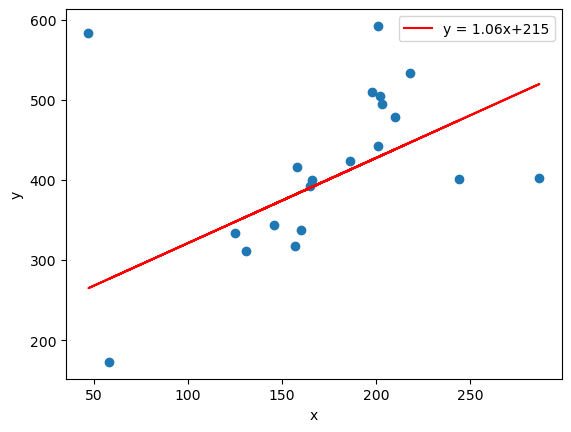

In [20]:
plt.scatter(x,y)
plt.plot(x,a[35]*x+b[71],label = 'y = 1.06x+215',color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected

In [26]:
filtered_y = sigma_clip(y, sigma=2,maxiters=5)
filtered_x = sigma_clip(x, sigma=2,maxiters=5)
index_y = np.where(filtered_y.mask == False)[0]
index_x = np.where(filtered_x.mask == False)[0]
index = np.intersect1d(index_y,index_x)

In [28]:
square_loss_filtered = squared_loss(x[index],y[index],dy[index],a,b)

In [29]:
np.where(square_loss_filtered==square_loss_filtered.min())

(array([63]), array([28]))

In [30]:
print ('a=',a[63],'\nb=',b[28])

a= 1.9090909090909092 
b= 84.84848484848484


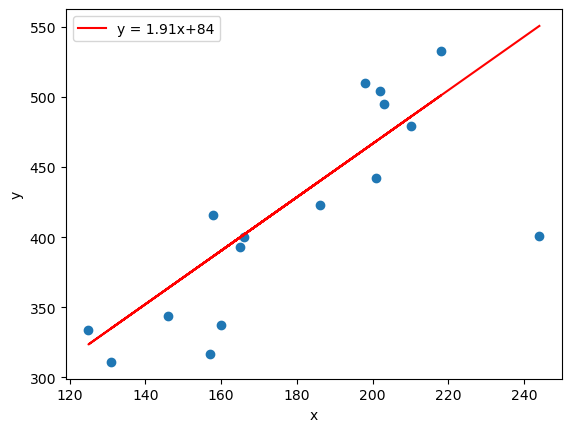

In [31]:
plt.scatter(x[index],y[index])
plt.plot(x[index],a[63]*x[index]+b[28],label = 'y = 1.91x+84',color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

and make a QQ plot of the residuals

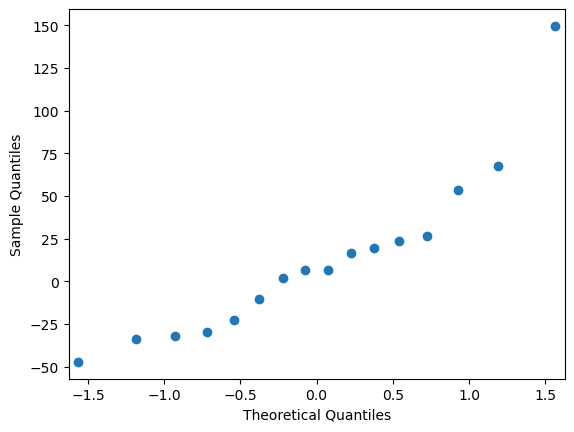

In [32]:
y_fit = a[63]*x[index]+b[28]
residual = y_fit-y[index]
sm.qqplot(residual)
plt.show()

Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties dy

In [72]:
def Huber_loss(params):
    a = params[0]
    b = params[1]
    y_predict = np.empty(len(x))
    for i in range(len(x)):
        y_predict[i] = a*x[i]+b
    loss = (y_predict-y)/dy
    if abs(sum(loss)) <= 8:
        Huber_loss = 0.5*sum(loss**2)
    else:
        Huber_loss = 8*(abs(sum(loss))-4)
    return Huber_loss

Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals

In [35]:
from scipy import optimize

In [73]:
minimum = optimize.fmin(Huber_loss,[2,100])
minimum

Optimization terminated successfully.
         Current function value: 32.000004
         Iterations: 58
         Function evaluations: 116


array([  1.78163696, 106.60926272])

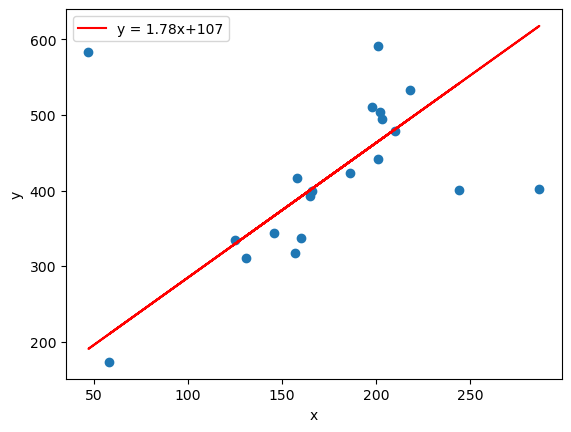

In [74]:
plt.scatter(x,y)
plt.plot(x,minimum[0]*x+minimum[1],label = 'y = 1.78x+107',color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

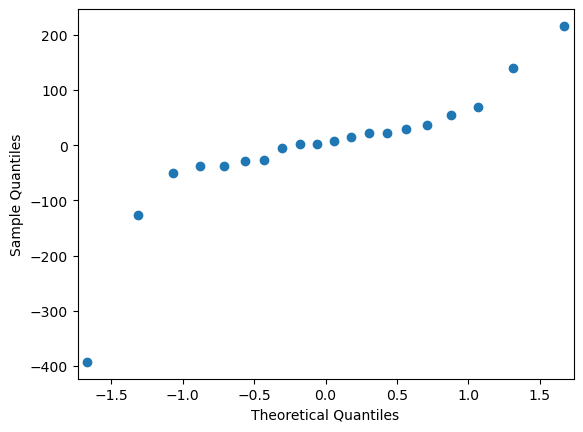

In [75]:
y_fit_huber = minimum[0]*x+minimum[1]
residual_huber = y_fit_huber-y
sm.qqplot(residual_huber)
plt.show()

In [87]:
cd

AidanBerres/         HaillePerkins/       SamMemon/
AkshatTripathi/      JosephWeller/        TaliZacks/
AlexGreen/           LiamNolan/           TestUser/
AmandaWasserman/     MaggieVerrico/       YujieWan/
AthishThiruvengadam/ QiaoyaWu/            ZacharyStone/
CameronTrimborn/     README.md
